# 2. Inspect and organize S1-RTC data processed by ASF

Now that we have read in and organized the stack of Sentinel-1 RTC images, this notebook will demonstrate preliminary dataset inspection. 

## Learning goals

**Techniques:**

- Comparing raster images
- Using `xr.groupby()` for [grouped statistics](https://docs.xarray.dev/en/stable/user-guide/groupby.html)
- Simple raster calculations
- Indexing and selection
- Visualizing multiple facets of the data using `FacetGrid`
- Reorganizing data with `xr.Dataset.reindex()`

**Science concepts:**

- Dataset inspection and evaluation


### ASF Data Access

You can download the RTC-processed backscatter time series [here](https://zenodo.org/record/7236413#.Y1rNi37MJ-0). For more detail, see [tutorial data](../background/tutorial_data.md#sentinel-1-rtc-datasets).

## Software and setup

In [49]:
%xmode minimal
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import warnings
import xarray as xr

import s1_tools

warnings.filterwarnings("ignore", category=UserWarning)

Exception reporting mode: Minimal


## A. Read + prepare data

We'll go through the steps shown in [metadata wrangling](2_wrangle_metadata.ipynb), but this time,  combined into one function from `s1_tools`. 

In [2]:
vv_vrt_path = '../data/vrt_files/s1_stackVV.vrt'
vh_vrt_path = '../data/vrt_files/s1_stackVH.vrt' 
ls_vrt_path = '../data/vrt_files/s1_stackLS.vrt' 

In [3]:
asf_data_cube = s1_tools.metadata_processor(vv_path= vv_vrt_path,
                                            vh_path= vh_vrt_path,
                                            ls_path= ls_vrt_path)

In [4]:
asf_data_cube

<xarray.Dataset> Size: 289GB
Dimensions:       (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x             (x) float64 140kB 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y             (y) float64 107kB 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref   int64 8B 0
  * acq_date      (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 2022...
    product_id    (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '1380' 'E5B6'
    data_take_ID  (acq_date) <U6 2kB '047321' '047463' ... '052C00' '052C00'
Data variables:
    ls            (acq_date, y, x) float32 96GB dask.array<chunksize=(11, 1536, 1536), meta=np.ndarray>
    vh            (acq_date, y, x) float32 96GB dask.array<chunksize=(11, 1536, 1536), meta=np.ndarray>
    vv            (acq_date, y, x) float32 96GB dask.array<chunksize=(11, 1536, 1536), meta=np.ndarray>
Attributes: (12/13)
    polarization_type:                 D
    unmasked_or_watermasked:           u
    beam_mode:                         IW
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    ...                                ...
    area_or_clipped:                   e
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    terrain_correction_pixel_spacing:  RTC30

Until now, we've kept the full spatial extent of the dataset. This hasn't been a problem because all of our operations have been lazy. Now, we'd like to start analyzing and visualizing the dataset so we will subset the data cube to a smaller area of interest.

Later notebooks use a different Sentinel-1 RTC dataset that is accessed for a smaller area of interest. We'll clip the current data cube to that spatial footprint now:

In [10]:
#Read vector data 
pc_aoi = gpd.read_file(
    "https://github.com/e-marshall/sentinel1_rtc/raw/main/hma_rtc_aoi.geojson"
)

Check the CRS and ensure it matches that of the raster data cube:

In [19]:
assert asf_data_cube.rio.crs == pc_aoi.crs, f'Expected: {asf_data_cube.rio.crs}, received: {pc_aoi.crs}'

Clip the raster data cube by the extent of the vector:

In [20]:
clipped_cube = asf_data_cube.rio.clip(pc_aoi.geometry,
                                      pc_aoi.crs)

Persist the dataset in memory so that later operations will be more efficient.

In [27]:
clipped_cube= clipped_cube.persist()

Great, we've gone from an object where each 3-d variable is ~ 90 GB to one where each 3-d variable is ~45 MB, this will be much easier to work with.

## B. Initial visualization

In [23]:
def plot_timestep(input_arr, time_step_int):
    """plots VV and VH polarizations of a given dataset at a given time step"""
    date = input_arr.isel(acq_date=time_step_int).acq_date.dt.date.data
    fig, axs = plt.subplots(ncols=3, figsize=(24, 7))

    input_arr.isel(acq_date=time_step_int).ls.plot(ax=axs[0])
    s1_tools.power_to_db(input_arr.isel(acq_date=time_step_int).vv).plot(
        ax=axs[1], cmap=plt.cm.Greys_r
    )
    s1_tools.power_to_db(input_arr.isel(acq_date=time_step_int).vh).plot(
        ax=axs[2], cmap=plt.cm.Greys_r
    )
    fig.suptitle(
        f"Layover-shadow mask (L), VV (C) and VH (R) backscatter {str(input_arr.isel(acq_date=time_step_int).acq_date.data)[:-19]}"
    )
    axs[0].set_title(f"{date} layover-shadow map")
    axs[1].set_title(f"{date} VV backscatter")
    axs[2].set_title(f"{date} VH backscatter")

## Layover-shadow mask

Each RTC image comes with a geotiff file containing a layover-shadow mask. This can help to understand missing data you might see in the imagery files. The layover shadow masks are coded to represent a number of different types of pixels:

The following information is copied from the README file that accompanies each scene: 

```{**Layover-shadow mask**}

The layover/shadow mask indicates which pixels in the RTC image have been affected by layover and shadow. This layer is tagged with _ls_map.tif

The pixel values are generated by adding the following values together to indicate which layover and shadow effects are impacting each pixel:
0.  Pixel not tested for layover or shadow
1.  Pixel tested for layover or shadow
2.  Pixel has a look angle less than the slope angle
4.  Pixel is in an area affected by layover
8.  Pixel has a look angle less than the opposite of the slope angle
16. Pixel is in an area affected by shadow

There are 17 possible different pixel values, indicating the layover, shadow, and slope conditions present added together for any given pixel._

The values in each cell can range from 0 to 31:
0.  Not tested for layover or shadow
1.  Not affected by either layover or shadow
3.  Look angle < slope angle
5.  Affected by layover
7.  Affected by layover; look angle < slope angle
9.  Look angle < opposite slope angle
11. Look angle < slope and opposite slope angle
13. Affected by layover; look angle < opposite slope angle
15. Affected by layover; look angle < slope and opposite slope angle
17. Affected by shadow
19. Affected by shadow; look angle < slope angle
21. Affected by layover and shadow
23. Affected by layover and shadow; look angle < slope angle
25. Affected by shadow; look angle < opposite slope angle
27. Affected by shadow; look angle < slope and opposite slope angle
29. Affected by shadow and layover; look angle < opposite slope angle
31. Affected by shadow and layover; look angle < slope and opposite slope angle

```

The ASF RTC image [product guide](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/) has detailed descriptions of how the data is processed and what is included in the processed dataset.

### Quick visualization

Let's look at VV and VH backscatter and the layover-shadow mask for a single time step:

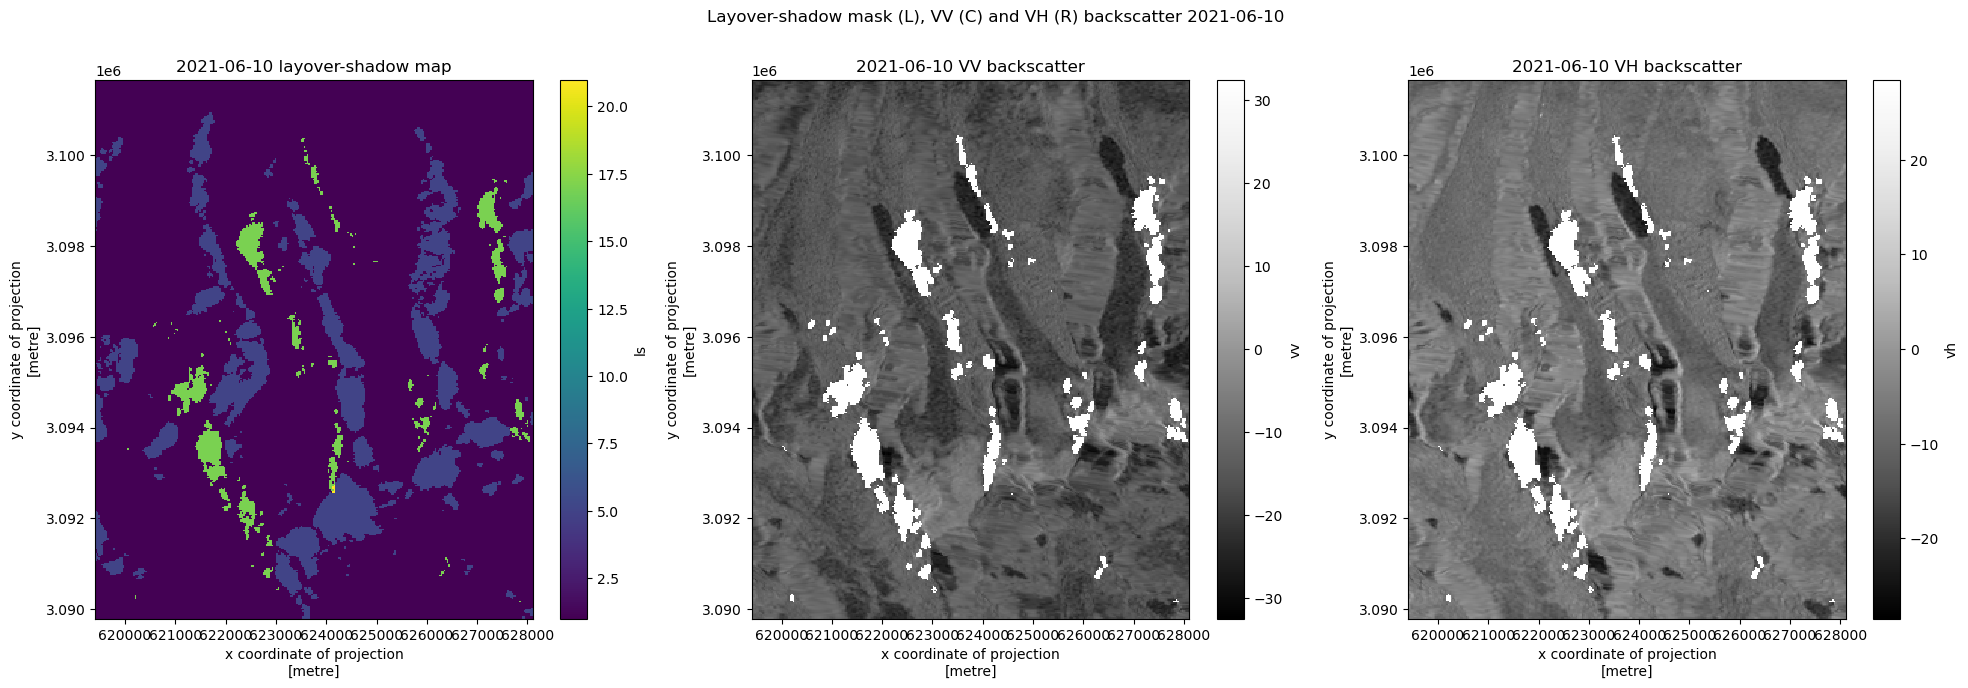

In [28]:
plot_timestep(clipped_cube, 11)

The `layover-shadow` variable provides categorical information. We can use a more appropriate colormap for this purpose:

In [30]:
cat_cmap = plt.colormaps["gist_ncar"].resampled(20)

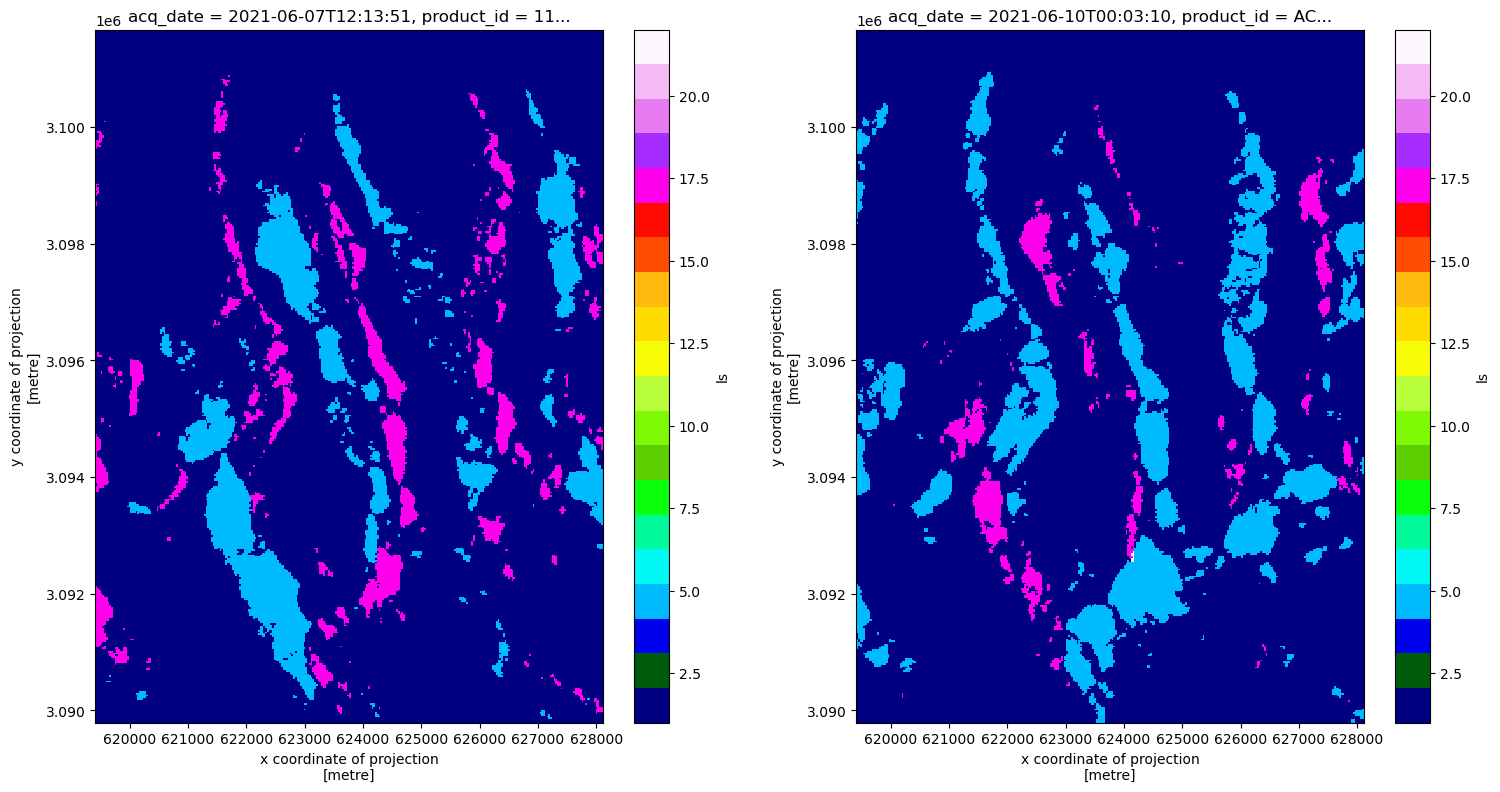

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 9))

clipped_cube.isel(acq_date=10).ls.plot(ax=axs[0], vmax=22, vmin=1, cmap=cat_cmap)
clipped_cube.isel(acq_date=11).ls.plot(ax=axs[1], vmax=22, vmin=1, cmap=cat_cmap);

It looks like there are areas affected by different types of distortion on different dates. For example, in the lower left quadrant, there is a region that is blue (5 - affected by layover) on 6/7/2021 but much of that area appears to be in radar shadow on 6/10/2021. This pattern is present throughout much of the scene with portions of area that are affected by layover in one acquisition in shadow in the next acquisition. This is due to different viewing geometries on different orbital passes: one of the above scenes was likely collected during an ascending pass and one during a descending.

## Orbital direction

Sentinel-1 is a right-looking sensor and it images areas on Earth's surface in orbits where it is moving N-S (a descending orbit) and S-N (an ascending orbit). It images the same footprint on both passes but from different directions. The data coverage map below illustrates these directional passes, it can be found online [here](https://asf.alaska.edu/daac/sentinel-1-acquisition-maps/)

```{image} ../imgs/slc_coverage_asf.png
:align center
```
ASF Sentinel-1 Cumulative coverage map.

In areas of high-relief topography such as the AOI we're using, there can be strong terrain distortion effects such as layover and shadow. The above image shows the layover-shadow map for an ascending and a descending image side-by-side, which is why different areas are affected by layover (5) and shadow (17) in each. 

Thanks to all the setup work we did in the previous notebook, we can quickly confirm that all of the observations were taken at two times of day, corresponding to ascending and descending passes of the satellite, and that the time steps shown above were taken at different times of day.

:::{note}
The acquisition time of Sentinel-1 images is not in local time.
:::

In [36]:
print('Hour of day of acquisition 10: ',clipped_cube.isel(acq_date = 10).acq_date.dt.hour.data)
print('Hour of day of acquisition 11: ', clipped_cube.isel(acq_date = 11).acq_date.dt.hour.data)
clipped_cube.acq_date.dt.hour

Hour of day of acquisition 10:  12
Hour of day of acquisition 11:  0


<xarray.DataArray 'hour' (acq_date: 103)> Size: 824B
array([12,  0, 12, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,
       12,  0, 12, 12, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12,
       12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0,
       12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,
        0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12,
       12,  0, 12, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12, 12, 12, 12,
       12])
Coordinates:
  * acq_date      (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 2022...
    product_id    (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '1380' 'E5B6'
    data_take_ID  (acq_date) <U6 2kB '047321' '047463' ... '052C00' '052C00'
    spatial_ref   int64 8B 0

### Is a pass ascending or descending?

While it is simple to determine one pass from another, it is not always straightforward to know if a pass is ascending or descending. The timing of these passes depends on the location on earth of the image. 

In the location covered by this dataset, ascending passes correspond to an acquisition time roughly 0:00 and descending passes correspond to approximately 12:00.

### Assign orbital direction as a coordinate

This is another example of time-varying metadata, so it should be stored as a coordinate variable.

In [37]:
clipped_cube.coords['orbital_dir'] = ('acq_date', xr.where(clipped_cube.acq_date.dt.hour.data== 0, 'asc','desc'))

## Looking at backscatter variability

Let's look at how VV and VH backscatter vary over time. Make a new Xarray object that holds the mean backscatter of VV and VH to visualize this more easily:

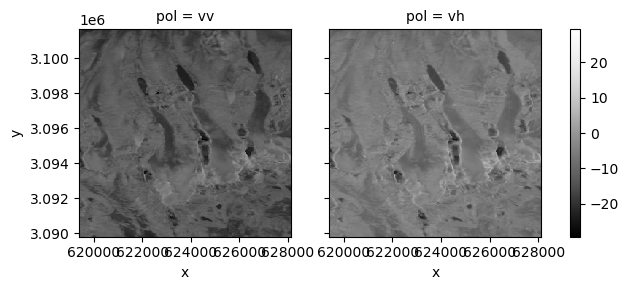

In [38]:
#Mean backscatter of both polarizations
mean_pol = xr.Dataset({"vv": clipped_cube['vv'].mean("acq_date"),
                        "vh": clipped_cube['vh'].mean("acq_date")})

s1_tools.power_to_db(mean_pol).to_array("pol").plot(col="pol", cmap=plt.cm.Greys_r);

Notice that the above plot uses Xarray's FacetGrid plotting, which means that we do'nt need to manually set the limits on the colorscale so that they are tied to both sub-plots.

Now let's look at how backscatter may vary seasonally for a single polarization (for more on time-related GroupBy operations see the [Xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations).

In [40]:
clipped_cube_gb = clipped_cube.groupby("acq_date.season").mean()

In [41]:
clipped_cube_gb

<xarray.Dataset> Size: 6MB
Dimensions:      (season: 4, y: 396, x: 290)
Coordinates:
  * x            (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 8B 0
  * season       (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    ls           (season, y, x) float32 2MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    vh           (season, y, x) float32 2MB 0.1108 0.1239 ... 0.2862 0.2956
    vv           (season, y, x) float32 2MB 0.02098 0.0221 ... 0.04669 0.04661
Attributes: (12/13)
    polarization_type:                 D
    unmasked_or_watermasked:           u
    beam_mode:                         IW
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    ...                                ...
    area_or_clipped:                   e
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    terrain_correction_pixel_spacing:  RTC30

In [42]:
# order seasons correctly
clipped_cube_gb = clipped_cube_gb.reindex({"season": ["DJF", "MAM", "JJA", "SON"]})
clipped_cube_gb

<xarray.Dataset> Size: 6MB
Dimensions:      (x: 290, y: 396, season: 4)
Coordinates:
  * x            (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * season       (season) <U3 48B 'DJF' 'MAM' 'JJA' 'SON'
    spatial_ref  int64 8B 0
Data variables:
    ls           (season, y, x) float32 2MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    vh           (season, y, x) float32 2MB 0.1108 0.1239 ... 0.2862 0.2956
    vv           (season, y, x) float32 2MB 0.02098 0.0221 ... 0.04669 0.04661
Attributes: (12/13)
    polarization_type:                 D
    unmasked_or_watermasked:           u
    beam_mode:                         IW
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    ...                                ...
    area_or_clipped:                   e
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    terrain_correction_pixel_spacing:  RTC30

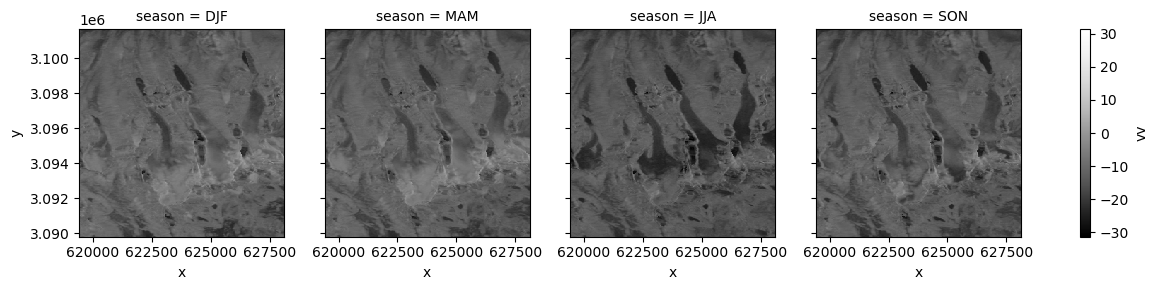

In [43]:
fg_ = s1_tools.power_to_db(clipped_cube_gb.vv).plot(col="season", cmap=plt.cm.Greys_r);

Interesting, it looks like the winter and spring composites are relatively similar to one another. There also appears to be a decrease in backscatter moving from spring to summer. 

## Handling duplicate time steps

If we take a closer look at the ASF dataset, we can see that there are a few scenes from identical acquisitions (can see this in `acq_date` and more specifically in `product_id`. Let's examine these and see what's going on, if we want to keep the duplicates: 

First we'll extract the data_date_id from the Sentinel-1 granule ID: 

In [46]:
clipped_cube

<xarray.Dataset> Size: 142MB
Dimensions:       (x: 290, y: 396, acq_date: 103)
Coordinates:
  * x             (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y             (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * acq_date      (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 2022...
    product_id    (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '1380' 'E5B6'
    data_take_ID  (acq_date) <U6 2kB '047321' '047463' ... '052C00' '052C00'
    spatial_ref   int64 8B 0
    orbital_dir   (acq_date) <U4 2kB 'desc' 'asc' 'desc' ... 'desc' 'desc'
Data variables:
    ls            (acq_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    vh            (acq_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    vv            (acq_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
Attributes: (12/13)
    polarization_type:                 D
    unmasked_or_watermasked:           u
    beam_mode:                         IW
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    ...                                ...
    area_or_clipped:                   e
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    terrain_correction_pixel_spacing:  RTC30

The length of the `asf_ids` list is exactly what we'd expect, 103. Let's look at the number of unique elements using [`np.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html).

In [58]:
data_take_ids_ls = clipped_cube.data_take_ID.data.tolist()

In [55]:
data_take_id_set = np.unique(clipped_cube.data_take_ID)

In [56]:
len(data_take_id_set)

96

Interesting - it looks like there are only 96 unique elements when we look at the `data_take_id`. Let's figure out which are duplicates:

In [53]:
def duplicate(input_ls):
    return list(set([x for x in input_ls if input_ls.count(x) > 1]))

In [59]:
duplicate_ls = duplicate(data_take_ids_ls)
duplicate_ls

['05154A', '052C00', '047898', '048D87', '0492D4']

These are the data take IDs that are duplicated in the dataset. We now want to subset the xarray object to only include these data take IDs: 

In [61]:
asf_duplicate_cond = clipped_cube.data_take_ID.isin(duplicate_ls)
asf_duplicate_cond

<xarray.DataArray 'data_take_ID' (acq_date: 103)> Size: 103B
array([False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True])
Coordinates:
  * acq_date      (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 2022...
    product_id    (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '1380' 'E5B6'
    data_take_ID  (acq_date) <U6 2kB '047321' '047463' ... '052C00' '052C00'
    spatial_ref   int64 8B 0
    orbital_dir   (acq_date) <U4 2kB 'desc' 'asc' 'desc' ... 'desc' 'desc'

In [63]:
duplicates_cube = clipped_cube.where(asf_duplicate_cond == True, drop=True)
duplicates_cube

<xarray.Dataset> Size: 17MB
Dimensions:       (acq_date: 12, y: 396, x: 290)
Coordinates:
  * x             (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y             (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * acq_date      (acq_date) datetime64[ns] 96B 2021-05-14T12:13:49 ... 2022-...
    product_id    (acq_date) <U4 192B '971C' 'FA4F' '0031' ... '1380' 'E5B6'
    data_take_ID  (acq_date) <U6 288B '047898' '047898' ... '052C00' '052C00'
    spatial_ref   int64 8B 0
    orbital_dir   (acq_date) <U4 192B 'desc' 'desc' 'desc' ... 'desc' 'desc'
Data variables:
    ls            (acq_date, y, x) float32 6MB 1.0 1.0 1.0 1.0 ... nan nan nan
    vh            (acq_date, y, x) float32 6MB 0.1432 0.1138 0.08822 ... nan nan
    vv            (acq_date, y, x) float32 6MB 0.01493 0.01373 ... nan nan
Attributes: (12/13)
    polarization_type:                 D
    unmasked_or_watermasked:           u
    beam_mode:                         IW
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    ...                                ...
    area_or_clipped:                   e
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    terrain_correction_pixel_spacing:  RTC30

Great, now we have a 12-time step xarray object that contains only the duplicate data takes. Let's see what it looks like. We can use `xr.FacetGrid` objects to plot these all at once: 

In [27]:
fg = asf_duplicates.vv.plot(col="acq_date", col_wrap=4)

ValueError: Coordinates used for faceting cannot contain repeated (nonunique) values.

Oops, we can't use faceting along the `acq_date` dimension here because of the repeated time steps that we want to look at. Xarray does not know how to handle these repeated values when it is creating the small multiples.

For now we'll ignore the repeated values to visualize what's present

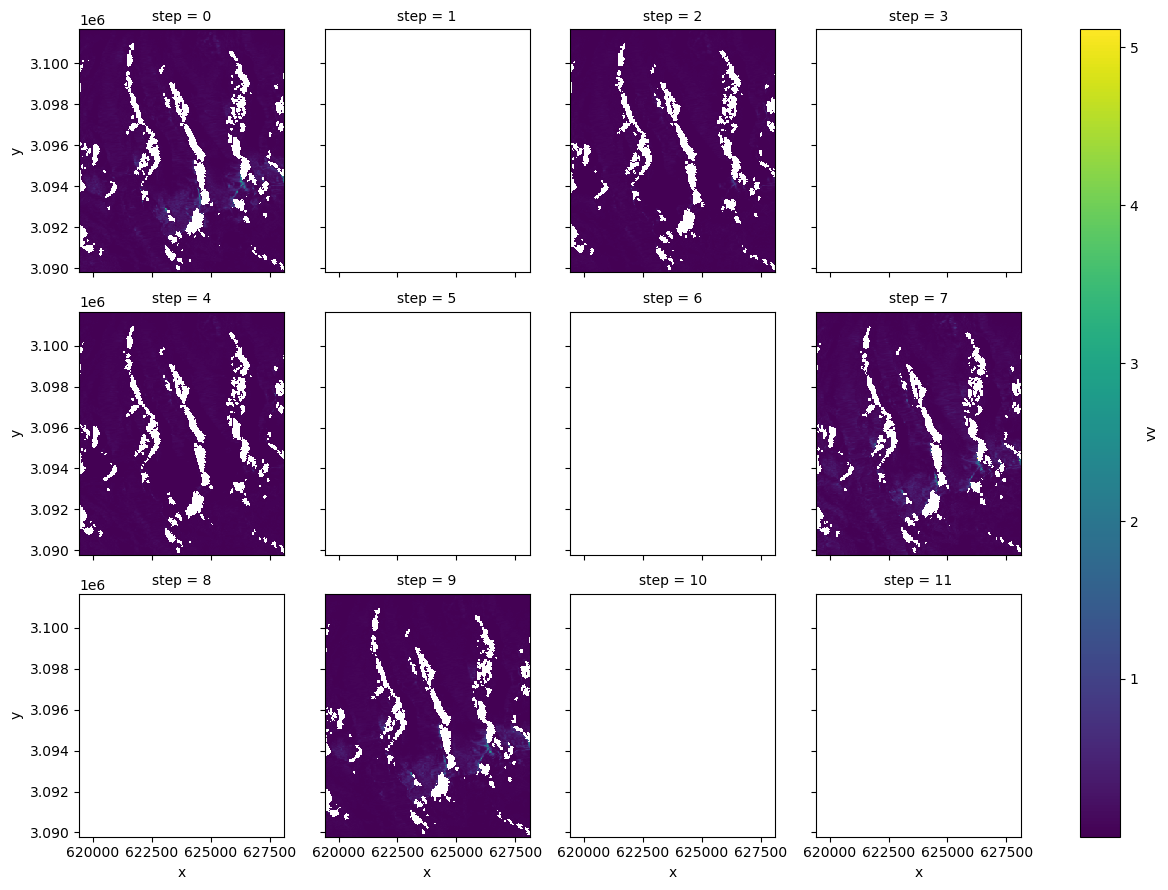

In [64]:
fg = duplicates_cube.rename_dims({"acq_date": "step"}).vv.plot(col="step", col_wrap=4)

Interesting, it looks like there's only really data for the 0, 2, 4, 7 and 9 elements of the list of duplicates.

To drop these, we need to extract the product ID of each duplicate we'd like to remove, since this is the only variable that is unique among the duplicates.

In [65]:
drop_ls = [1, 3, 5, 6, 8, 10, 11]

We can use xarray's `.isel()` method, `.xr.DataArray.isin()`, `xr.Dataset.where()`, and list comprehension to efficiently subset the time steps we want to keep: 

In [66]:
drop_product_id_ls = duplicates_cube.isel(acq_date=drop_ls).product_id.data

In [67]:
drop_product_id_ls

array(['FA4F', '65E0', 'E113', '24B8', '57F2', '1380', 'E5B6'],
      dtype='<U4')

Using this list, we want to drop all of the elements of `vrt_full` where product Id is one of the values in the list.

In [68]:
duplicate_cond = ~clipped_cube.product_id.isin(drop_product_id_ls)

In [69]:
clipped_cube = clipped_cube.where(duplicate_cond == True, drop=True)

In [71]:
clipped_cube

<xarray.Dataset> Size: 132MB
Dimensions:       (acq_date: 96, y: 396, x: 290)
Coordinates:
  * x             (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y             (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * acq_date      (acq_date) datetime64[ns] 768B 2021-05-02T12:14:14 ... 2022...
    product_id    (acq_date) <U4 2kB '1424' '54B1' '8A4F' ... '7418' 'CA1B'
    data_take_ID  (acq_date) <U6 2kB '047321' '047463' ... '0529DD' '052C00'
    spatial_ref   int64 8B 0
    orbital_dir   (acq_date) <U4 2kB 'desc' 'asc' 'desc' ... 'desc' 'desc'
Data variables:
    ls            (acq_date, y, x) float32 44MB nan nan nan nan ... 1.0 1.0 1.0
    vh            (acq_date, y, x) float32 44MB nan nan nan ... 0.3252 0.3992
    vv            (acq_date, y, x) float32 44MB nan nan nan ... 0.0375 0.03803
Attributes: (12/13)
    polarization_type:                 D
    unmasked_or_watermasked:           u
    beam_mode:                         IW
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    ...                                ...
    area_or_clipped:                   e
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    terrain_correction_pixel_spacing:  RTC30

In [72]:
clipped_cube.to_zarr("../data/tutorial2/asf_clipped_cube.zarr", mode="w")

## Wrap up 

This notebook gives a brief look in to the vast amount of auxiliary data that is contained within this dataset. Making the most and best use of this dataset requires familiarity with the the many different types of information it includes. 